# Sydney Airbnb Data Exploration
## by Hao Xu

## Preliminary Wrangling


This document explores **Sydney Airbnb Dataset**.  [This data set](https://www.kaggle.com/tylerx/sydney-airbnb-open-data) is from kaggle.


In [1]:
# import all packages and set plots to be embedded inline

# packages for data process and visalization
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# packages for plot on map
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import contextily as ctx
import geoplot as gplt

# packages for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# packages for text process
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline


In [2]:
# load the listing summary dataset
sl_df = pd.read_csv('sydney_listings_summary_dec18.csv')
print(sl_df.shape)
sl_df.head()

(36662, 16)


id                                               name  host_id  \
0  12351                  Sydney City & Harbour at the door    17061   
1  14250                                Manly Harbour House    55948   
2  15253  Stunning Penthouse Apartment In Heart Of The City    59850   
3  20865                 3 BED HOUSE + 1 BED STUDIO Balmain    64282   
4  26174                 COZY PRIVATE ROOM, GREAT LOCATION!   110561   

  host_name  neighbourhood_group neighbourhood   latitude   longitude  \
0    Stuart                  NaN        Sydney -33.865153  151.191896   
1     Heidi                  NaN         Manly -33.800929  151.261722   
2     Morag                  NaN        Sydney -33.880455  151.216541   
3     Fiona                  NaN    Leichhardt -33.859072  151.172753   
4    Amanda                  NaN     Woollahra -33.889087  151.259404   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    100               2                493  2018-11-21   
1  Entire home/apt    471               5                  1  2016-01-02   
2     Private room    109               2                300  2018-11-16   
3  Entire home/apt    450               7                 15  2018-01-07   
4     Private room     62               1                 42  2018-11-23   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               4.83                               2               187  
1               0.03                               2               321  
2               3.63                               2               316  
3               0.18                               1                69  
4               0.45                               1               140

In [3]:
print(sl_df.dtypes)
sl_df.isnull().sum()

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


id                                    0
name                                 12
host_id                               0
host_name                             6
neighbourhood_group               36662
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       11937
reviews_per_month                 11937
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [4]:
# convert 'last_review' datatype to datetime
sl_df.last_review = sl_df.last_review.astype("datetime64")
# drop neighbourhood_group for all values are null
sl_df.drop(columns = {'neighbourhood_group'}, inplace = True)

In [5]:
# load the calendar summary dataset
sc_df = pd.read_csv('sydney_calendar_dec18.csv')
print(sc_df.shape)
sc_df.head()

(13381265, 4)


listing_id        date available    price
0       14250  2019-12-06         t  $470.00
1       12351  2019-08-17         t  $110.00
2       12351  2019-08-16         t  $110.00
3       12351  2019-08-15         t  $110.00
4       12351  2019-08-14         t  $110.00

In [6]:
print(sc_df.dtypes)
sc_df.isnull().sum()

listing_id     int64
date          object
available     object
price         object
dtype: object


listing_id          0
date                0
available           0
price         9810841
dtype: int64

In [7]:
# convert date column to datetime64
sc_df.date = sc_df.date.astype("datetime64")
# change the available column values to 1 and 0
sc_df.available = sc_df.available.apply(lambda x : 1 if x == 't' else 0)

In [8]:
# convert price from string to float
def getnum(price):
    '''
    INPUT:
    price - a string format price with the first character of '$' and ',' inside
            or a interger
    
    OUTPUT:
    price - int type price
    '''

    if type(price) != str:
        return price
    else:
        return ''.join(price[1:].split(','))

sc_df.price = sc_df.price.apply(getnum)
sc_df.price = sc_df.price.apply(float)

In [9]:
# loading sydney_reviews_dec18
sr_df = pd.read_csv('sydney_reviews_dec18.csv')
print(sr_df.shape)
sr_df.head()

(446708, 6)


listing_id      id        date  reviewer_id reviewer_name  \
0       12351   68394  2010-07-24        45760          Anna   
1       12351   76453  2010-08-09       148786        Stuart   
2       12351   83283  2010-08-23       190202         Angel   
3       12351   91580  2010-09-06       219308         Meisy   
4       12351  100903  2010-09-20       191976         Dayna   

                                            comments  
0  This was my first Airbnb experience and I am h...  
1  As my first AirBnB experience, this was a magn...  
2  Like many others this was my first AirBnB expe...  
3  Vinh and Stuart were very warm and hospitable,...  
4  I had a wonderful experience staying with Vinh...

In [10]:
print(sr_df.dtypes)
sr_df.isnull().sum()

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object


listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         447
dtype: int64

In [11]:
# convert date datatype
sr_df.date = sr_df.date.astype("datetime64")

In [12]:
sl_df

id                                               name    host_id  \
0         12351                  Sydney City & Harbour at the door      17061   
1         14250                                Manly Harbour House      55948   
2         15253  Stunning Penthouse Apartment In Heart Of The City      59850   
3         20865                 3 BED HOUSE + 1 BED STUDIO Balmain      64282   
4         26174                 COZY PRIVATE ROOM, GREAT LOCATION!     110561   
...         ...                                                ...        ...   
36657  30592081                             The top floor paradise  229475098   
36658  30592161   Sydney harbour catamaran sailing. Parties for 10  223580521   
36659  30592248  Double Room built-in a large and bright apartment  119396721   
36660  30592505     Bright Modern apartment in a Premiere location  229479027   
36661  30593866   Huge Sunny Double Room with Spa in Best Location   51138070   

             host_name neighbourhood   latitude   longitude        room_type  \
0               Stuart        Sydney -33.865153  151.191896     Private room   
1                Heidi         Manly -33.800929  151.261722  Entire home/apt   
2                Morag        Sydney -33.880455  151.216541     Private room   
3                Fiona    Leichhardt -33.859072  151.172753  Entire home/apt   
4               Amanda     Woollahra -33.889087  151.259404     Private room   
...                ...           ...        ...         ...              ...   
36657          Sharney     Woollahra -33.874940  151.259375  Entire home/apt   
36658            Blake    Canada Bay -33.847841  151.149573  Entire home/apt   
36659           Nelson   Strathfield -33.863719  151.081721     Private room   
36660   Sofei & Kelvin      Rockdale -33.929960  151.150659  Entire home/apt   
36661  Aaron & Natalie        Sydney -33.906938  151.211255     Private room   

       price  minimum_nights  number_of_reviews last_review  \
0        100               2                493  2018-11-21   
1        471               5                  1  2016-01-02   
2        109               2                300  2018-11-16   
3        450               7                 15  2018-01-07   
4         62               1                 42  2018-11-23   
...      ...             ...                ...         ...   
36657    190              10                  0         NaT   
36658    900               1                  0         NaT   
36659     46               4                  0         NaT   
36660    170               2                  0         NaT   
36661     80               5                  0         NaT   

       reviews_per_month  calculated_host_listings_count  availability_365  
0                   4.83                               2               187  
1                   0.03                               2               321  
2                   3.63                               2               316  
3                   0.18                               1                69  
4                   0.45                               1               140  
...                  ...                             ...               ...  
36657                NaN                               1               172  
36658                NaN                               1               168  
36659                NaN                               1                11  
36660                NaN                               1                89  
36661                NaN                               3                11  

[36662 rows x 15 columns]

### What is the structure of the dataset?
Sydney Airbnb Open Data contains 6 datasets and 1 geojson file. I will use 3 datasets and the geojson file in it.

The first dataset sl_df(short for 'Sydeny list dataframe') contains 36,663 records with 15 features. This dataset has a unique key ('id'), most of the features are numeric variables, 
including two spetial features('latitude' and 'longitude'), one datetime feature and several ordinary numeric features. This dataset also has two important categorical features, 'neighbourhood' and 'room type'

The second dataset sc_df('Sydney calendar dataframe') contains 13,381,265 records, it's just 365 times of records in the first dataset. This dataset has 4 features: listing_id, date, available and price, I will use them for a time series analysis.

The third dataset sr_df('Sydney reviews dataframe') contains 446,708 rows, I will use its comment column.

The last two datasets both have a foreign key that match the primary key of the first dataset, I can join these datasets on this ID key.

### My most interesting questions

1. How professional operator chooses the location? 
2. What's the trend of availabel room quantity and price with in a year?
3. What factors affect the house price more?
4. What are the several unique words most used by reviewers to describe each neighbourhood?

### 1. How professional operator chooses the location? 

In [13]:
# set a new column, if owner only has this one room, marked as low
# if owner has 2 to 4 rooms('calculated_host_listings_count' is 2 to 4), marker as medium,
# if owner has more than 4 rooms, marker as high
def L_to_H(count):
    '''
    INPUT:
    count - positive int
    
    OUTPUT:
    str - if count is 1, return low
          if count between 2 and 4, return medium
          if large or equal to 5, return high
    '''
    if count == 1:
        return 'Low'
    if count >=2 and count<=4:
        return 'Medium'
    if count >= 5:
        return 'High'

sl_df['owner_own_rooms'] = sl_df['calculated_host_listings_count'].apply(L_to_H)

In [14]:
# set the new column to orered categorical type
order = ['Low','Medium','High']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = order)
sl_df['owner_own_rooms'] = sl_df['owner_own_rooms'].astype(ordered_var)

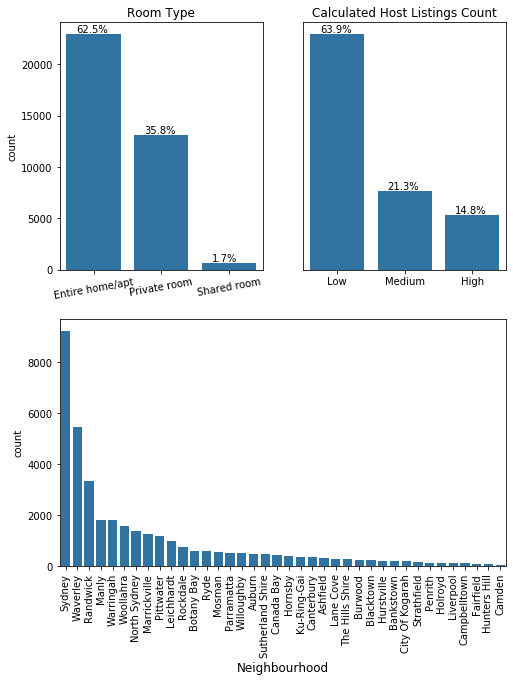

In [15]:
# take a look at the univariate distribution of 3 features(neighbourhood,room_type and calculated_host_listings_count)
base_color = sns.color_palette()[0]
plt.figure(figsize = [8,10])

plt.subplot(2,2, 1)
sns.countplot(data = sl_df, x = 'room_type',color = base_color,
              order = sl_df.room_type.value_counts().index)
plt.title('Room Type')
plt.xlabel('')
plt.xticks(rotation = 10)
for i in range (3):
    count = sl_df.room_type.value_counts()[i]
    pct_string = '{:.1%}'.format(count/sl_df.shape[0])
    plt.text(i-0.25,count+200,pct_string, va = 'baseline',fontsize = 10);

plt.subplot(2, 2, 2)
sns.countplot(data = sl_df, x = 'owner_own_rooms',color = base_color,
              order =sl_df.owner_own_rooms.value_counts().index) 
plt.title('Calculated Host Listings Count')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
for i in range (3):
    count = sl_df.owner_own_rooms.value_counts()[i]
    pct_string = '{:.1%}'.format(count/sl_df.shape[0])
    plt.text(i-0.25,count+200,pct_string, va = 'baseline',fontsize = 10);

plt.subplot(2, 2, (3,4))
sns.countplot(data = sl_df, x = 'neighbourhood',color = base_color,
              order = sl_df.neighbourhood.value_counts().index)
plt.xticks(rotation = 90)
plt.xlabel('Neighbourhood',fontsize = 12)
plt.show();



The vast majority of the room types are Entire home and Private room, only 1.7% is shared room.

Most of airbnb houses(63.9%) are owned by someone only have one airbnb property. Other 36.9% are owned by owners with at least 2 airbnb properties.

Sydney, Waverley and Randwick neighbourhood have the most rooms.

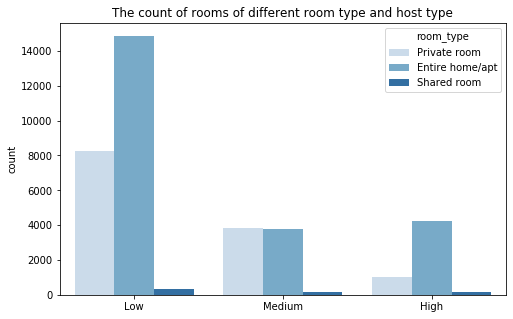

In [16]:
## room types vs host count

plt.figure(figsize = [8, 5])

sns.countplot(data = sl_df, x = 'owner_own_rooms', hue = 'room_type', palette = 'Blues')
plt.xlabel('Calculated Host Listings Count')
plt.title('The count of rooms of different room type and host type')
plt.xlabel('')
plt.show();

There are more than 8000 hosts only have 1 room, and this room is a private room. It means they are sharing one room of their house to do the business.

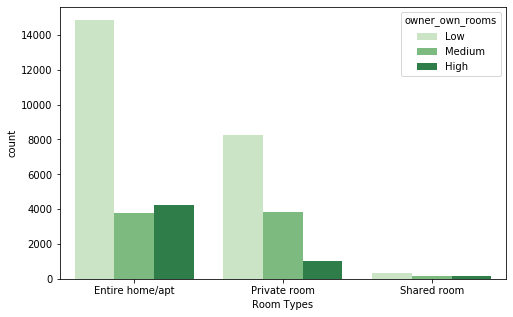

In [17]:
## host count vs room type

plt.figure(figsize = [8, 5])

sns.countplot(data = sl_df, x = 'room_type', hue = 'owner_own_rooms', palette = 'Greens',
              order = sl_df.room_type.value_counts().index)
plt.xlabel('Room Types')
plt.show();

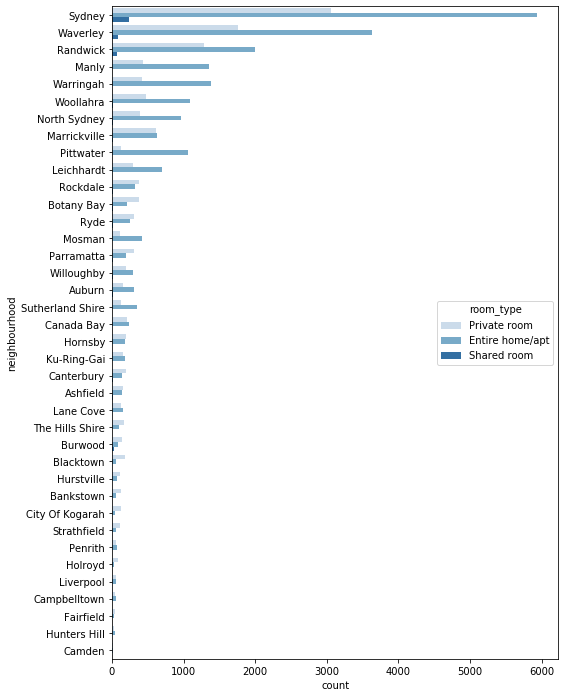

In [18]:
# room type vs host count

plt.figure(figsize = [8, 12])

sns.countplot(data = sl_df, y = 'neighbourhood', hue = 'room_type', palette = 'Blues',
              order = sl_df.neighbourhood.value_counts().index)
plt.show();

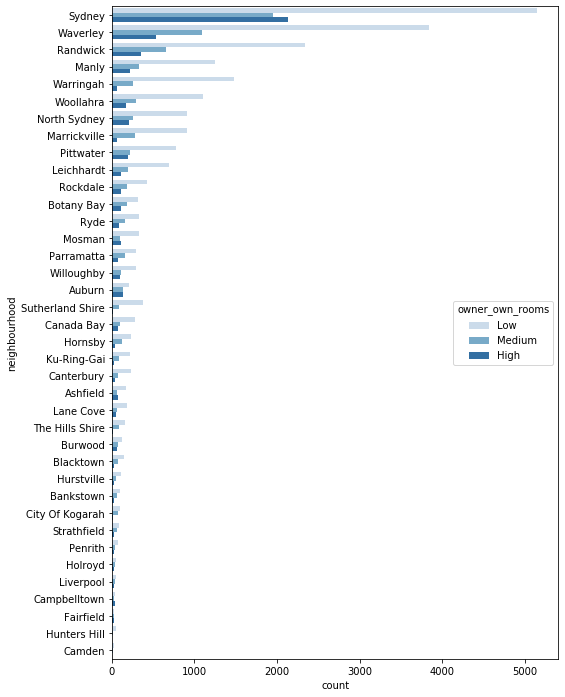

In [19]:
# room type vs host count

plt.figure(figsize = [8, 12])

sns.countplot(data = sl_df, y = 'neighbourhood', hue = 'owner_own_rooms', palette = 'Blues',
              order = sl_df.neighbourhood.value_counts().index)
plt.show();

This dataset contains spetial information, I'd like to plot the data on a map using geopandas. First, I want to plot a heat map of average price of each neighbourhood.

In [20]:
# read neighbourhoods.geojson from the zip file, and set the CRS
area = gpd.read_file('neighbourhoods.geojson')
area.crs = {'init' :'epsg:4326'};
area.shape

(38, 3)

In [21]:
# add a average price column to the geopandas dataset
price_area = area.merge(sl_df.groupby('neighbourhood').price.mean().reset_index(),on = 'neighbourhood' )
price_area


neighbourhood neighbourhood_group  \
0          Pittwater                None   
1           Randwick                None   
2           Waverley                None   
3          Warringah                None   
4          Lane Cove                None   
5       North Sydney                None   
6          Bankstown                None   
7         Canterbury                None   
8        Strathfield                None   
9             Auburn                None   
10   The Hills Shire                None   
11      Hunters Hill                None   
12            Sydney                None   
13        Botany Bay                None   
14        Hurstville                None   
15         Fairfield                None   
16         Blacktown                None   
17           Holroyd                None   
18          Ashfield                None   
19      Marrickville                None   
20  Sutherland Shire                None   
21          Rockdale                None   
22   City Of Kogarah                None   
23        Parramatta                None   
24              Ryde                None   
25        Leichhardt                None   
26           Hornsby                None   
27       Ku-Ring-Gai                None   
28        Willoughby                None   
29         Liverpool                None   
30           Penrith                None   
31        Canada Bay                None   
32            Camden                None   
33      Campbelltown                None   
34            Mosman                None   
35             Manly                None   
36         Woollahra                None   
37           Burwood                None   

                                             geometry       price  
0   MULTIPOLYGON (((151.29613 -33.57292, 151.29618...  496.598154  
1   MULTIPOLYGON (((151.23722 -33.89075, 151.23731...  188.197848  
2   MULTIPOLYGON (((151.28337 -33.86183, 151.28334...  243.328334  
3   MULTIPOLYGON (((151.21140 -33.61521, 151.21157...  266.167781  
4   MULTIPOLYGON (((151.16634 -33.80621, 151.16650...  300.107266  
5   MULTIPOLYGON (((151.21456 -33.81583, 151.21461...  203.515328  
6   MULTIPOLYGON (((151.03244 -33.88828, 151.03248...   93.844444  
7   MULTIPOLYGON (((151.11418 -33.89578, 151.11461...  113.474926  
8   MULTIPOLYGON (((151.08398 -33.85785, 151.08417...  102.707602  
9   MULTIPOLYGON (((151.07934 -33.82243, 151.07958...  143.456290  
10  MULTIPOLYGON (((150.98469 -33.38708, 150.98402...  157.803846  
11  MULTIPOLYGON (((151.14072 -33.81820, 151.14082...  271.855072  
12  MULTIPOLYGON (((151.20872 -33.85365, 151.20872...  175.168813  
13  MULTIPOLYGON (((151.22350 -33.92556, 151.22358...  118.245000  
14  MULTIPOLYGON (((151.10101 -33.94044, 151.10111...  121.738462  
15  MULTIPOLYGON (((150.83641 -33.82075, 150.84129...   82.697368  
16  MULTIPOLYGON (((150.87482 -33.65789, 150.87512...   84.223629  
17  MULTIPOLYGON (((150.95169 -33.78895, 150.95184...   97.152000  
18  MULTIPOLYGON (((151.14857 -33.87044, 151.14859...  140.281046  
19  MULTIPOLYGON (((151.12851 -33.90478, 151.12861...  121.911342  
20  MULTIPOLYGON (((150.99909 -33.98287, 150.99949...  200.726496  
21  MULTIPOLYGON (((151.15586 -33.92777, 151.15590...  125.727023  
22  MULTIPOLYGON (((151.13624 -33.96963, 151.13627...   98.424581  
23  MULTIPOLYGON (((151.00106 -33.77342, 151.00109...  106.859615  
24  MULTIPOLYGON (((151.10937 -33.76259, 151.10945...  110.980870  
25  MULTIPOLYGON (((151.18548 -33.84599, 151.18582...  218.558559  
26  MULTIPOLYGON (((150.99299 -33.38719, 150.99306...  149.974425  
27  MULTIPOLYGON (((151.16657 -33.66387, 151.16673...  159.341176  
28  MULTIPOLYGON (((151.20891 -33.77860, 151.20900...  185.812000  
29  MULTIPOLYGON (((150.79755 -33.88088, 150.79781...  125.646552  
30  MULTIPOLYGON (((150.71072 -33.61437, 150.71102...  153.136364  
31  MULTIPOLYGON (((151.11509 -33.85001, 151.11509...  159.917595  
32  MULTIPOLYGON (((150.70829 -33.93884, 150.7

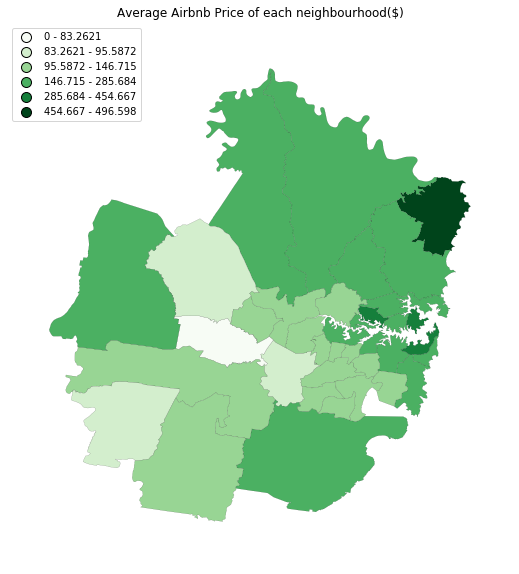

In [22]:
gplt.choropleth(price_area, hue='price', edgecolor='black', linewidth=0.1,
                cmap='Greens', legend=True, scheme='Percentiles', figsize = (10,10))
plt.title('Average Airbnb Price of each neighbourhood($)')
plt.show();

Overall, average Airbnb prices of neighbourhood near water(see or bay) are higher than prices not near water.

The Pittwater area have the highest average price. This heighbourhood is famous for its great sea view and large houses, since there are almost no apartments in the area, the number of available houses is relatively not enough. These factors lead to higher airbnb prices.

Neighbourhoods around the Sydney harbour water have the second highest prices, for these areas are well-known tourist destination.

Next, I want to plot the house on the map base on their latitude and longitude. There is a problem, the  the polygon data in the neighbourhood.geojason file is relatively rough, do not have enough Granularity, I try to find another .shp file with higher granular from [this link](https://web2.spatialvision.com.au/wp-content/uploads/2019/01/geopandas-blog.zip)

In [23]:
# load .shp file
aus_poas = gpd.read_file('aus_poas.shp')
aus_poas.head()

POA_NAME  code state                                           geometry
0     6000  6000  None  POLYGON ((115.86782 -31.95340, 115.86782 -31.9...
1     6003  6003  None  MULTIPOLYGON (((115.85039 -31.94570, 115.85065...
2     6004  6004  None  POLYGON ((115.86782 -31.95340, 115.86781 -31.9...
3     6005  6005  None  POLYGON ((115.84809 -31.93646, 115.84809 -31.9...
4     6006  6006  None  POLYGON ((115.84641 -31.92420, 115.84635 -31.9...

In [24]:
# filt out the polygon data of NSW, and set the CRS to 'epsg:4326'
syd_poas = aus_poas.query('code>= 2000 & code <= 3000 ')
syd_poas.crs = {'init' :'epsg:4326'};

In [25]:
# add the geometry featurn to sl_df, and set CRS
geometry = [Point(xy) for xy in zip(sl_df['longitude'],sl_df['latitude'])]
crs = {'init':'epsg:4326'}

geo_df = gpd.GeoDataFrame(sl_df,crs = crs, geometry = geometry)
geo_df.head()

id                                               name  host_id  \
0  12351                  Sydney City & Harbour at the door    17061   
1  14250                                Manly Harbour House    55948   
2  15253  Stunning Penthouse Apartment In Heart Of The City    59850   
3  20865                 3 BED HOUSE + 1 BED STUDIO Balmain    64282   
4  26174                 COZY PRIVATE ROOM, GREAT LOCATION!   110561   

  host_name neighbourhood   latitude   longitude        room_type  price  \
0    Stuart        Sydney -33.865153  151.191896     Private room    100   
1     Heidi         Manly -33.800929  151.261722  Entire home/apt    471   
2     Morag        Sydney -33.880455  151.216541     Private room    109   
3     Fiona    Leichhardt -33.859072  151.172753  Entire home/apt    450   
4    Amanda     Woollahra -33.889087  151.259404     Private room     62   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0               2                493  2018-11-21               4.83   
1               5                  1  2016-01-02               0.03   
2               2                300  2018-11-16               3.63   
3               7                 15  2018-01-07               0.18   
4               1                 42  2018-11-23               0.45   

   calculated_host_listings_count  availability_365 owner_own_rooms  \
0                               2               187          Medium   
1                               2               321          Medium   
2                               2               316          Medium   
3                               1                69             Low   
4                               1               140             Low   

                      geometry  
0  POINT (151.19190 -33.86515)  
1  POINT (151.26172 -33.80093)  
2  POINT (151.21654 -33.88045)  
3  POINT (151.17275 -33.85907)  
4  POINT (151.25940 -33.88909)

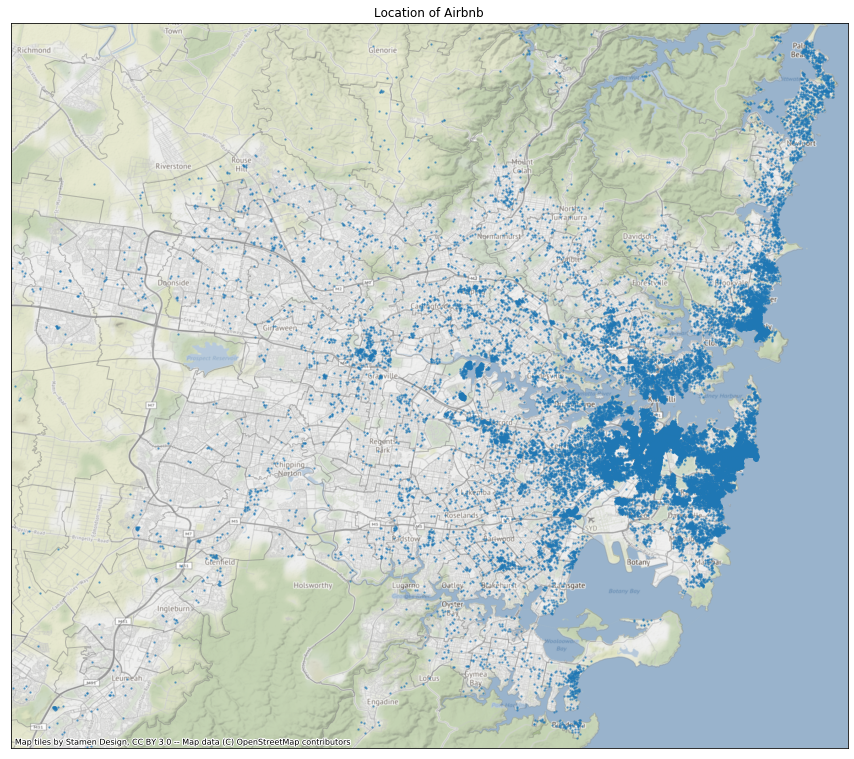

In [26]:
# plot all houses on the map
fig,ax = plt.subplots(figsize = (15,15))
syd_poas.plot(ax = ax, alpha = 0.3,color= 'white', edgecolor='gray')
plt.scatter(data = geo_df, x = 'longitude', y = 'latitude', s =2, alpha= 0.5)
plt.xlim(150.75,151.35)
plt.ylim(-34.1,-33.58)
plt.xticks([])
plt.yticks([])
plt.title('Location of Airbnb')
# add basemape to have a more clearly view 
ctx.add_basemap(ax, crs=aus_poas.crs,zoom=12);


The vast majority of the Airbnb properties are located along the west coast and around the Syndey harber waters. In the inner of Sydney, Airbnb properties locations are following the train line, such as T1(from from North Sydney to Hornsby) and T2(from Central to Parramatta).

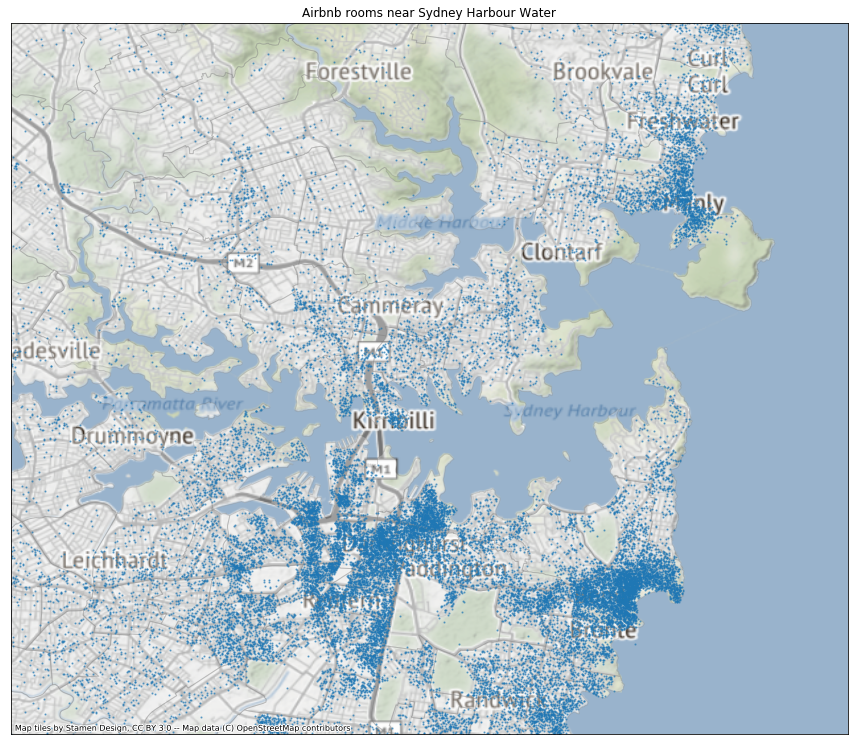

In [27]:
# zoom out the xlim and ylim, to to have a more clear view around Sydney Harbour area
fig,ax = plt.subplots(figsize = (15,15))
syd_poas.plot(ax = ax, alpha = 0.3,color= 'white', edgecolor='gray')
plt.scatter(data = geo_df, x = 'longitude', y = 'latitude', s = 1.5,alpha= 0.5)
plt.xlim(151.125,151.325)
plt.ylim(-33.925,-33.755)
plt.xticks([])
plt.yticks([])
plt.title('Airbnb rooms near Sydney Harbour Water')
ctx.add_basemap(ax, crs=aus_poas.crs,zoom=12);

After focusing on the core area of Sydeny, Airbnb properties highly clustered in three areas, around CBD, around Bondi beach and around Manly beach. They are the most popular area of Sydney for the tourists even for locals, and there are a lot of apartments.

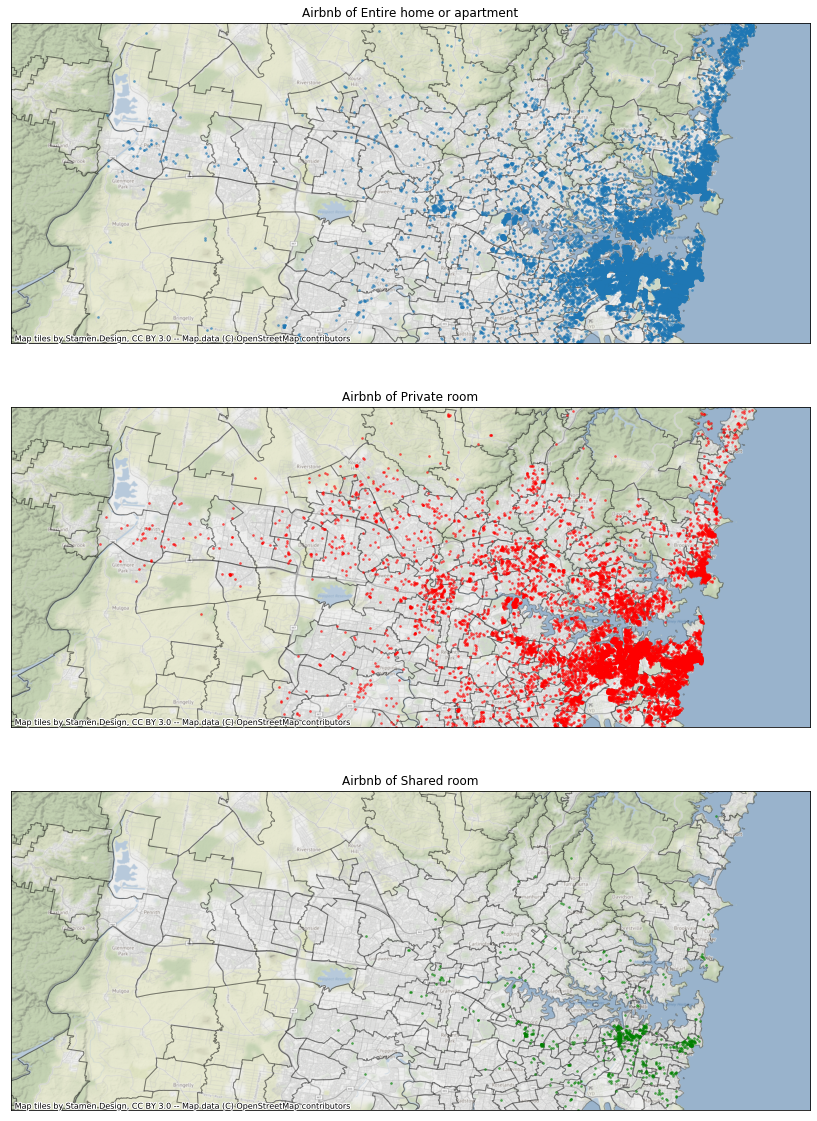

In [28]:
# get 3 subplots on the room type
fig,ax = plt.subplots(3,1,figsize = (15,20))
syd_poas.plot(ax = ax[0], alpha = 0.3,color= 'white', edgecolor='k')
ax[0].scatter(data = geo_df[geo_df['room_type'] == 'Entire home/apt'], x = 'longitude', 
              y = 'latitude', s = 3,alpha= 0.5)
ax[0].set_xlim(150.55,151.4)
ax[0].set_ylim(-33.96,-33.62)
ctx.add_basemap(ax[0], crs={'init': 'epsg:4326'}, zoom=12)
ax[0].set_title('Airbnb of Entire home or apartment')
ax[0].set_xticks([])
ax[0].set_yticks([]);

syd_poas.plot(ax = ax[1], alpha = 0.3,color= 'white', edgecolor='k')
ax[1].scatter(data = geo_df[geo_df['room_type'] == 'Private room'], x = 'longitude', 
              y = 'latitude', c= 'red',s = 3,alpha= 0.5)
ax[1].set_xlim(150.55,151.4)
ax[1].set_ylim(-33.96,-33.62)
ctx.add_basemap(ax[1], crs={'init': 'epsg:4326'}, zoom=12)
ax[1].set_title('Airbnb of Private room')
ax[1].set_xticks([])
ax[1].set_yticks([]);

syd_poas.plot(ax = ax[2], alpha = 0.3,color= 'white', edgecolor='k')
ax[2].scatter(data = geo_df[geo_df['room_type'] == 'Shared room'], x = 'longitude', 
              y = 'latitude', c= 'green',s = 3,alpha= 0.5)
ax[2].set_xlim(150.55,151.4)
ax[2].set_ylim(-33.96,-33.62)
ctx.add_basemap(ax[2], crs={'init': 'epsg:4326'}, zoom=12);
ax[2].set_title('Airbnb of Shared room')
ax[2].set_xticks([])
ax[2].set_yticks([]);

We can see entire home/apt mostly located in the city central area or alone the seaside，except that there is some gathering in Parramata, most of them are located on the east side of the city.

Private rooms are more widely distributed, but these located in Pittwater(that area have the highset average Airbnb price as just analysied) is much less than entire home/apt.

As for the shared room, because it is too small in quantity, it is only distributed around CBD and Bondi beach area.

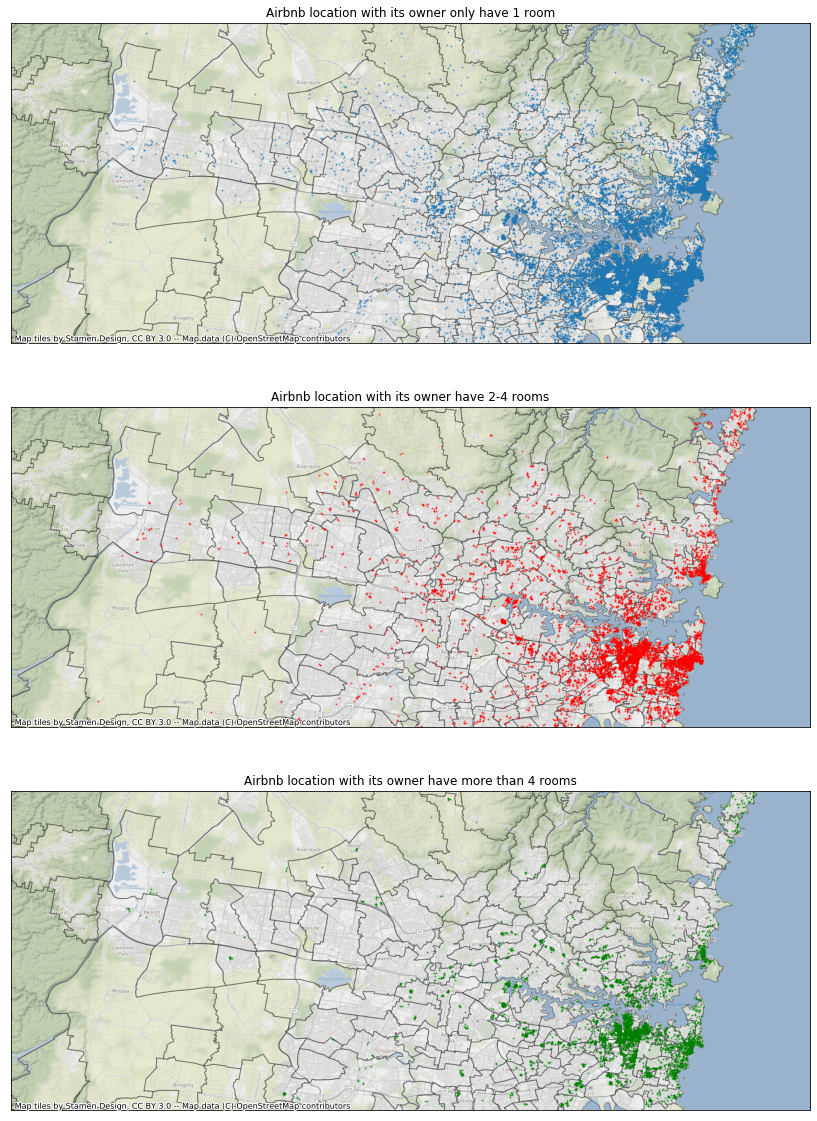

In [29]:
# at last get 3 subplots on the owners have how many airbnb properties
fig,ax = plt.subplots(3,1,figsize = (15,20))
syd_poas.plot(ax = ax[0], alpha = 0.3,color= 'white', edgecolor='k')
ax[0].scatter(data = geo_df[geo_df['owner_own_rooms'] == 'Low'], x = 'longitude', y = 'latitude', s = 1,alpha= 0.5)
ax[0].set_xlim(150.55,151.4)
ax[0].set_ylim(-33.96,-33.62)
ctx.add_basemap(ax[0], crs={'init': 'epsg:4326'}, zoom=12)
ax[0].set_title('Airbnb location with its owner only have 1 room')
ax[0].set_xticks([])
ax[0].set_yticks([]);

syd_poas.plot(ax = ax[1], alpha = 0.3,color= 'white', edgecolor='k')
ax[1].scatter(data = geo_df[geo_df['owner_own_rooms'] == 'Medium'], x = 'longitude', y = 'latitude', c= 'red',s = 1,alpha= 0.5)
ax[1].set_xlim(150.55,151.4)
ax[1].set_ylim(-33.96,-33.62)
ctx.add_basemap(ax[1], crs={'init': 'epsg:4326'}, zoom=12)
ax[1].set_title('Airbnb location with its owner have 2-4 rooms')
ax[1].set_xticks([])
ax[1].set_yticks([]);

syd_poas.plot(ax = ax[2], alpha = 0.3,color= 'white', edgecolor='k')
ax[2].scatter(data = geo_df[geo_df['owner_own_rooms'] == 'High'], x = 'longitude', y = 'latitude', c= 'green',s = 1,alpha= 0.5)
ax[2].set_xlim(150.55,151.4)
ax[2].set_ylim(-33.96,-33.62)
ctx.add_basemap(ax[2], crs={'init': 'epsg:4326'}, zoom=12);
ax[2].set_title('Airbnb location with its owner have more than 4 rooms')
ax[2].set_xticks([])
ax[2].set_yticks([]);


If classify owners who operate more than 4 stores as specializing in airbnb business, from the 3rd plot, I can find professional owners always choose the 3 hottest area or several surburb center to do their business.

Owners who operate 4 or less rooms affected by location of property owned, their Airbnb business are more widely distributed.

The answer to the first question, Is room type and host listing counts has any regional distribution pattern? I find:

- Compare to entire home/apt and shared room, Private room has the largest quantity, and have the widest distribution. But in some hottest area, especailly in north seaside(from Pittwater to Manly), they are obviously less than entire home/apt.

- Professional Airbnb operator like to run their business at the highest 3 clustered areas, one reason is there is a lot of demand, another reason is there are many apartments can be rent to run this business.

Now, I have seen the big picture of Sydney Airbnb industry, next, I will dig into its available rate and price by time series analysis.

### 2. What's the trend of availabel room quantity and price during a year?

This time, I will use sc_df to see the 'available' and 'price' features.

In [30]:
# use datetime as index for better time series analysis
sc_df.set_index('date',inplace = True)

In [31]:
# check null values
print(sc_df.isnull().sum())
print('sc_df has ',sc_df.shape[0], 'rows')
print('sc_df has ',sc_df.shape[0] - sc_df.available.sum(), 'rows are not available')
print('All rooms have average ', (1 - sc_df.available.sum()/sc_df.shape[0])*100, '% time not available')

listing_id          0
available           0
price         9810841
dtype: int64
sc_df has  13381265 rows
sc_df has  9810841 rows are not available
All rooms have average  73.31773939160459 % time not available


I can see the count of null price is the same of not available rows(both `9810841`), when the room is not available, there will be no price, the price column will be null. I will not need to deal with this value. Becaues when I try to get the mean value of price, Python will ignore these rows automaticly.

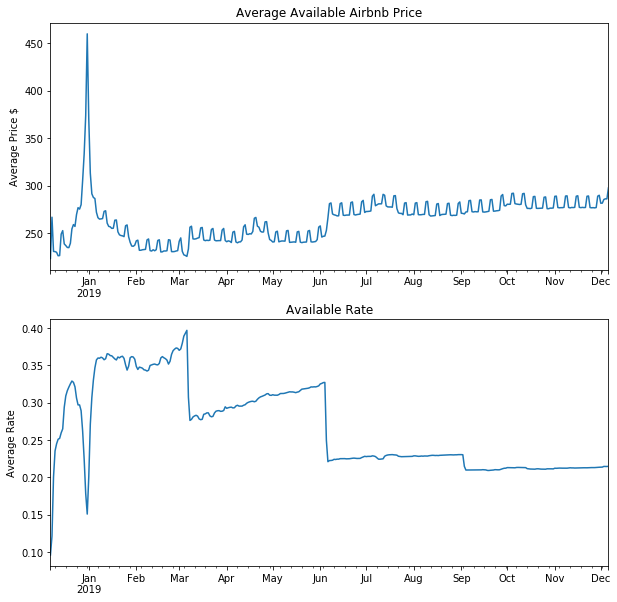

In [32]:
# get two time serier line plot
fig,ax = plt.subplots(2,1,figsize = (10,10))
sc_df.resample('D').price.mean().plot(ax = ax[0],kind='line')
ax[0].set_title('Average Available Airbnb Price')
ax[0].set_ylabel('Average Price $')
ax[0].set_xlabel('')

sc_df.resample('D').available.mean().plot(ax = ax[1], kind='line')
ax[1].set_title('Available Rate')
ax[1].set_ylabel('Average Rate')
ax[1].set_xlabel('')

plt.show();

There is a lot of information ：

- The price has a very obvious weekly pattern, on average, there will be an about 10 AUD increase at the weekend than weekdays.
- The available rate shows an obvious step-like distribution. From January to early March, Airbnb available is the highest of the year, and the price is the lowest. Then in the first week of Mar, Jun, and Sep, the available rate decreases dramatically, especially at the beginning of Mar and Jun, the average rate has a more than 10% decrease. The price follows the opposite trend.
- Because of large demand, around Christman and new year's day, there is a price spike, the available room's price is about twice as usual. The available rate is also the lowest of the year. But after the holiday, the price and available rate will return to normal quickly.
- As a city in the southern hemisphere, After the highest demand around new year's day has been released, Sydney comes into the hottest period of the year, I think that's why Sydney has the highest available rate at that time. The best times to visit Sydney are September through November(spring season) and from March to May(autumn season), the increasing demand leads to the available rate dropping in March and September. As for the changes in June, I think it may due to the summer season in the northern hemisphere and some countries have summer vacations.

Next, I will separate the dataset into two parts and to see the time trend separately

In [33]:
# check the value_count of neighbourhood

print(sl_df.neighbourhood.value_counts())


Sydney              9241
Waverley            5467
Randwick            3346
Manly               1800
Warringah           1794
Woollahra           1573
North Sydney        1370
Marrickville        1252
Pittwater           1192
Leichhardt           999
Rockdale             729
Botany Bay           600
Ryde                 575
Mosman               534
Parramatta           520
Willoughby           500
Auburn               469
Sutherland Shire     468
Canada Bay           449
Hornsby              391
Ku-Ring-Gai          340
Canterbury           339
Ashfield             306
Lane Cove            289
The Hills Shire      260
Burwood              249
Blacktown            237
Hurstville           195
Bankstown            180
City Of Kogarah      179
Strathfield          171
Penrith              132
Holroyd              125
Liverpool            116
Campbelltown         101
Fairfield             76
Hunters Hill          69
Camden                29
Name: neighbourhood, dtype: int64


These 10 neighbourhoods totally have   76.46609568490535 % airbnb of Sydney.


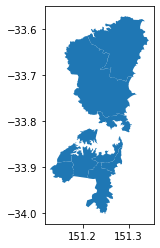

In [34]:
# check the location and total pencentage of first 10 neighbourhood
first_10 = sl_df.neighbourhood.value_counts().index[:10]
area.query('neighbourhood in @first_10').plot()
print('These 10 neighbourhoods totally have  ',
      (sl_df.neighbourhood.value_counts()/sl_df.shape[0]).values[:10].sum()* 100,
     '% airbnb of Sydney.')


The first 10 neighbour hood are all famous waterside areas, they totally have more than 3/4 Airbnb rooms of all Sydney. I will split the dataset here.

In [35]:
sub_list = sl_df.neighbourhood.value_counts().index

# separate the neighbourhood into two parts from Ryde, neighbourhood before Ryde are mostly for
# tourists, neighbourhood after Ryde are most for business and other
sub_H = sub_list[:10]
sub_L = sub_list[10:]

# get the id list of both neighbourhood parts
id_H =sl_df.query('neighbourhood in @sub_H').id.value_counts().index
id_L =sl_df.query('neighbourhood in @sub_L').id.value_counts().index 

# split the sc_df dataset
sc_df_H = sc_df.query('listing_id in @id_H')
sc_df_L = sc_df.query('listing_id in @id_L')

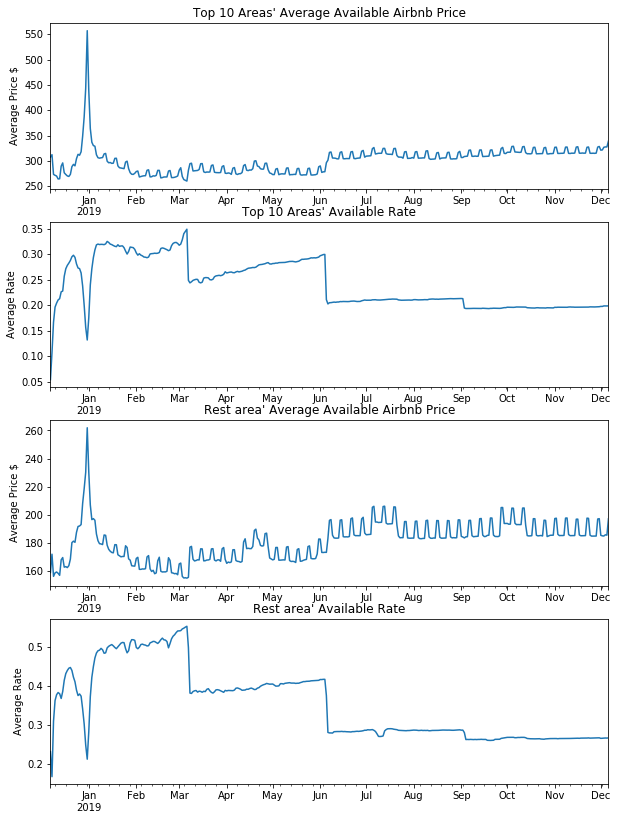

In [42]:
# plot the average price and available rate of the first half of the dataset
fig,ax = plt.subplots(4,1,figsize = (10,14))
sc_df_H.resample('D').price.mean().plot(ax = ax[0],kind='line')
ax[0].set_title('Top 10 Areas\' Average Available Airbnb Price')
ax[0].set_ylabel('Average Price $')
ax[0].set_xlabel('')

sc_df_H.resample('D').available.mean().plot(ax = ax[1], kind='line')
ax[1].set_title('Top 10 Areas\' Available Rate')
ax[1].set_ylabel('Average Rate')
ax[1].set_xlabel('')

sc_df_L.resample('D').price.mean().plot(ax = ax[2],kind='line')
ax[2].set_title('Rest area\' Average Available Airbnb Price')
ax[2].set_ylabel('Average Price $')
ax[2].set_xlabel('')

sc_df_L.resample('D').available.mean().plot(ax = ax[3], kind='line')
ax[3].set_title('Rest area\' Available Rate')
ax[3].set_ylabel('Average Rate')
ax[3].set_xlabel('')

plt.show();

It shows that, in the first 10 neighbourhood, despite the large supply of rooms(more than 75% of all city's supply), demand is still very strong. 

- In the first 10 neighbourhood, the average price of avaialble room is about 320 AUD, available rate is less than 30% at most of the time. And the highest price can reach 550 AUD.
- In the left 28 neighbourhood, the average price of avaialble room is about 180 AUD, available rate is less than 50% at most of the time. And the highest price can only reach 260 AUD.

We can see, in the first 10 area, more supply, but still higher price and low available rate, means demand distribution is very uneven, most of the needs are clustered in several regions. So if someone want to enter this industry, its better to run their business in the first 10 areas.

I will move to my next question, using machine learning to see What features of the dataset affect the house price more.

## 3. What factors affect the house price more?

In [45]:
# check the columns of the sl_df
sl_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'owner_own_rooms',
       'geometry'],
      dtype='object')

sl_df actually contains all quantity information of the other two datasets(sc_df and sr_df)
'number_of_reviews' is the count of 'commits' of sr_df, 'availability_365' is the sum of available column of sc_df. As I want to see what affect the price, I will use 'price' of sl_df as the explained variable, I will give up the 'price' feature of sc_df.

In [46]:
# find out all useful columns, and make a copy
cal_df = sl_df[['neighbourhood','room_type','price','minimum_nights','number_of_reviews',
                'reviews_per_month','calculated_host_listings_count', 'availability_365']].copy()
cal_df


neighbourhood        room_type  price  minimum_nights  \
0            Sydney     Private room    100               2   
1             Manly  Entire home/apt    471               5   
2            Sydney     Private room    109               2   
3        Leichhardt  Entire home/apt    450               7   
4         Woollahra     Private room     62               1   
...             ...              ...    ...             ...   
36657     Woollahra  Entire home/apt    190              10   
36658    Canada Bay  Entire home/apt    900               1   
36659   Strathfield     Private room     46               4   
36660      Rockdale  Entire home/apt    170               2   
36661        Sydney     Private room     80               5   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                    493               4.83                               2   
1                      1               0.03                               2   
2                    300               3.63                               2   
3                     15               0.18                               1   
4                     42               0.45                               1   
...                  ...                ...                             ...   
36657                  0                NaN                               1   
36658                  0                NaN                               1   
36659                  0                NaN                               1   
36660                  0                NaN                               1   
36661                  0                NaN                               3   

       availability_365  
0                   187  
1                   321  
2                   316  
3                    69  
4                   140  
...                 ...  
36657               172  
36658               168  
36659                11  
36660                89  
36661                11  

[36662 rows x 8 columns]

There are 6 numeric features 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'
and 2 categorical features:'neighbourhood' and 'room_type'

In [47]:
cal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36662 entries, 0 to 36661
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   36662 non-null  object 
 1   room_type                       36662 non-null  object 
 2   price                           36662 non-null  int64  
 3   minimum_nights                  36662 non-null  int64  
 4   number_of_reviews               36662 non-null  int64  
 5   reviews_per_month               24725 non-null  float64
 6   calculated_host_listings_count  36662 non-null  int64  
 7   availability_365                36662 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.2+ MB


In [48]:
# check the null values
cal_df.isnull().sum()

neighbourhood                         0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 11937
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [49]:
# from the sr_df dataset to find how many id have commit
sr_df.listing_id.value_counts()

12351       493
898906      475
7944819     474
389876      443
12954762    425
           ... 
14242318      1
20040221      1
28772451      1
26457008      1
21901910      1
Name: listing_id, Length: 24725, dtype: int64

These two number matches, in sl_df, there are 24725 rows have number_of_reviews values, its just the same as the id counts with any commits.

So, any room have no commits will show null value in 'reviews_per_month' column of sl_df. I only need to fill these null with 0, because they do not have any review commite. 

In [50]:
# fill the null value with 0
cal_df['reviews_per_month'] = cal_df['reviews_per_month'].fillna(0)
cal_df.isnull().sum()

neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [51]:
# set a create_dummy_df function to convert all categorical features into dummy variables
def create_dummy_df(df, cat_cols, dummy_na = False):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:

        df = pd.concat([df.drop(col,axis = 1),
                        pd.get_dummies(df[col],prefix = col,prefix_sep = '_',
                                       drop_first = True, dummy_na = dummy_na)], 
                       axis = 1)
    
    return df

In [52]:
# get dummy features from the two categorical features
cat_cols_lst = cal_df.select_dtypes(include = ['object']).columns

# there is no need to deal with null values, 
cal_df_new = create_dummy_df(cal_df, cat_cols_lst, dummy_na=False)
cal_df_new.shape

(36662, 45)

In [55]:
# make a regression

# Split full_df_new into an X matrix and a response vector y
y = cal_df_new['price']
X = cal_df_new.drop('price',axis = 1)

# Create training and test sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2) 
 
    
# Instantiate a LinearRegression model with normalized data
lm_model = LinearRegression(normalize=True) 
        
# Fit the model to the training data
lm_model.fit(X_train, y_train) 
    

# Predict the response for the training data and the test data
y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 

# get the r2 score of both test data and train data
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
    

In [56]:
print('test_score is:  ',test_score)
print('train_score is:  ',train_score)

test_score is:   0.1361034393975804
train_score is:   0.13433926415990183


The regression show's these features can only explain about 13% of the price changing. I think that's reasonable, features such as room area, indoor facilities, parking space, renovation time， whether to provide meals, traffic convenience, ect, are all very important.

In order to have better regression score, I find more information in `listings_dec18.csv` file. For not too complicated, I will add several important features : 'host_is_superhost','host_identity_verified','accommodates','bathrooms','beds'

In [57]:
full_list_df = pd.read_csv('listings_dec18.csv')
print(full_list_df.shape)
full_list_df.head()

(36662, 96)


/Users/xuhao3/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,61,62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id                         listing_url       scrape_id last_scraped  \
0  12351  https://www.airbnb.com/rooms/12351  20181207034750   2018-12-07   
1  14250  https://www.airbnb.com/rooms/14250  20181207034750   2018-12-07   
2  15253  https://www.airbnb.com/rooms/15253  20181207034750   2018-12-07   
3  20865  https://www.airbnb.com/rooms/20865  20181207034750   2018-12-07   
4  26174  https://www.airbnb.com/rooms/26174  20181207034750   2018-12-07   

                                                name  \
0                  Sydney City & Harbour at the door   
1                                Manly Harbour House   
2  Stunning Penthouse Apartment In Heart Of The City   
3                 3 BED HOUSE + 1 BED STUDIO Balmain   
4                 COZY PRIVATE ROOM, GREAT LOCATION!   

                                             summary  \
0  Come stay with Vinh & Stuart (Awarded as one o...   
1  Beautifully renovated, spacious and quiet, our...   
2  Penthouse living in a great central location: ...   
3  Hi! We are a married professional couple with ...   
4                                                NaN   

                                               space  \
0  We're pretty relaxed hosts, and we fully appre...   
1  Our home is a thirty minute walk along the sea...   
2  A charming two-level, two-bedroom, two-bathroo...   
3  HOUSE : _________ * DUCTED AIR CONDITIONING IN...   
4  Double bed in decent sized bedroom, in two bed...   

                                         description experiences_offered  \
0  Come stay with Vinh & Stuart (Awarded as one o...                none   
1  Beautifully renovated, spacious and quiet, our...                none   
2  Penthouse living in a great central location: ...                none   
3  Hi! We are a married professional couple with ...                none   
4  Double bed in decent sized bedroom, in two bed...                none   

                               neighborhood_overview  ... requires_license  \
0  Pyrmont is an inner-city village of Sydney, on...  ...                f   
1  Balgowlah Heights is one of the most prestigio...  ...                f   
2  The location is really central and there is nu...  ...                f   
3  BALMAIN is an older inner city village / subur...  ...                f   
4                                                NaN  ...                f   

  license jurisdiction_names instant_bookable is_business_travel_ready  \
0     NaN                NaN                f                        f   
1     NaN                NaN                f                        f   
2     NaN                NaN                t                        f   
3     NaN                NaN                f                        f   
4     NaN                NaN                f                        f   

           cancellation_policy  require_guest_profile_picture  \
0  strict_14_with_grace_period                              t   
1  strict_14_with_grace_period                              f   
2  strict_14_with_grace_period                              f   
3  strict_14_with_grace_period                              t   
4                     moderate                              f   

  require_guest_phone_verification  calculated_host_listings_count  \
0                                t                               2   
1                                f                               2   
2                                f                               2   
3                                t                               1   
4                                f                               1   

   reviews_per_month  
0               4.83  
1               0.03  
2               3.63  
3               0.18  
4               0.45  

[5 rows x 96 columns]

In [58]:
full_list_df.host_response_time.count()

18778

In [59]:
# get the interesting features
interest_df = full_list_df[['id','host_is_superhost','host_identity_verified','accommodates','bathrooms','bedrooms','beds']]

# join with the sl_df
sl_df2 = sl_df.merge(interest_df,on = 'id',how = 'left')


In [60]:
sl_df2.shape

(36662, 23)

In [61]:
cal_df = sl_df2[['neighbourhood','room_type','price','minimum_nights','number_of_reviews',
                'reviews_per_month','calculated_host_listings_count', 'availability_365',
                'host_is_superhost','host_identity_verified','accommodates','bathrooms',
                'bedrooms','beds']].copy()
print(cal_df.shape)
cal_df.isnull().sum()

(36662, 14)


neighbourhood                         0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 11937
calculated_host_listings_count        0
availability_365                      0
host_is_superhost                     6
host_identity_verified                6
accommodates                          0
bathrooms                            19
bedrooms                              9
beds                                 39
dtype: int64

In [62]:
# deal with null values just as above
cal_df['reviews_per_month'] = cal_df['reviews_per_month'].fillna(0)



host_is_superhost,host_identity_verified,bathrooms,beds only have very few null values(less than 1/1000)
I will drop these rows.

In [63]:
cal_df = cal_df.dropna(axis = 0, how = 'any')
cal_df.shape

(36600, 14)

In [64]:
# get dummy features from the two categorical features
cat_cols_lst = cal_df.select_dtypes(include = ['object']).columns

# there is no need to deal with null values, 
cal_df_new = create_dummy_df(cal_df, cat_cols_lst, dummy_na=False)
cal_df_new.shape

(36600, 51)

In [75]:
# make a regression

# Split full_df_new into an X matrix and a response vector y
y = cal_df_new['price']
X = cal_df_new.drop('price',axis = 1)

# Create training and test sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1) 
 
    
# Instantiate a LinearRegression model with normalized data
lm_model = LinearRegression(normalize=True) 
        
# Fit the model to the training data
lm_model.fit(X_train, y_train) 
    

# Predict the response for the training data and the test data
y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 

# get the r2 score of both test data and train data
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
    

In [76]:
print('test_score is:  ',test_score)
print('train_score is:  ',train_score)

test_score is:   0.3063113826255387
train_score is:   0.31744310805456244


The regression show's these features can explain about more than 30% of the price changing, That's much better. 
Finally, I want to see within this 13% of explaination, what featurs are more important.

In [77]:
# make a regression
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

est_int       coefs   abs_coefs
15  neighbourhood_Campbelltown -178.402562  178.402562
34     neighbourhood_Pittwater  150.009497  150.009497
27     neighbourhood_Liverpool -133.169159  133.169159
30        neighbourhood_Mosman  119.592730  119.592730
25     neighbourhood_Lane Cove  105.204003  105.204003
45     neighbourhood_Woollahra  104.743928  104.743928
6                    bathrooms  100.108745  100.108745
33       neighbourhood_Penrith  -88.492770   88.492770
43      neighbourhood_Waverley   82.739259   82.739259
28         neighbourhood_Manly   74.210983   74.210983
14        neighbourhood_Camden  -69.834438   69.834438
20       neighbourhood_Holroyd  -66.368100   66.368100
23    neighbourhood_Hurstville  -65.298689   65.298689
5                 accommodates   59.230758   59.230758
31  neighbourhood_North Sydney   53.954561   53.954561
47       room_type_Shared room  -53.498344   53.498344
24   neighbourhood_Ku-Ring-Gai  -53.259843   53.259843
11     neighbourhood_Blacktown  -51.970107   51.970107
10     neighbourhood_Bankstown  -45.358873   45.358873
40        neighbourhood_Sydney   44.056814   44.056814

I can see, within these features I run the regression, the neighbourhood is the most important features, number of batherooms/accommodates and roomtype are also important.

My last interesting question is 'What are the top 5 unique words used by reviewers to discribe each neighbourhood', I will use the sr_df dataset.

### 4. What are the top 5 unique words used by reviewers to discribe each neighbourhood?

In [78]:
# commites are in sr_df dataset, this dataset do not have neighbourhoon column, I need to add
# this column by inner join the sl_df and sr_df
id_sub_df = sl_df[['id','neighbourhood']]
sr_df = sr_df.merge(id_sub_df,left_on = 'listing_id', right_on = 'id')


In [79]:
# To prevent few commit from being str,
sr_df['comments'] = sr_df['comments'].astype(str)
print(sr_df.shape)
sr_df.shape

(446708, 8)


(446708, 8)

In [80]:
# first I want to see what's the average words counts within each neighbourhood 
sr_df['word_count'] = sr_df['comments'].apply(lambda x:len(x.split(' ')))
# get a list of average commite word counts of each neighbourhood
count_df = sr_df.groupby('neighbourhood').word_count.mean().sort_values(ascending=False).reset_index()


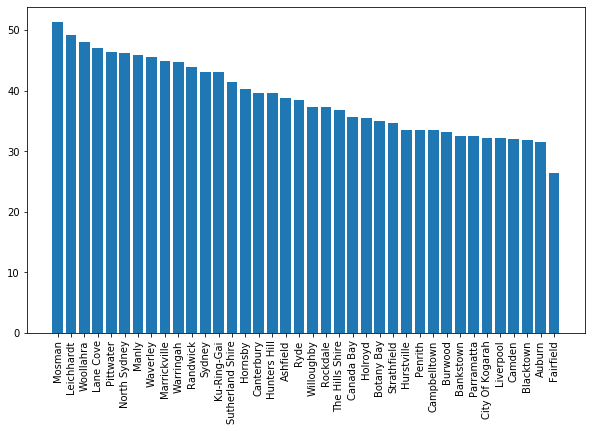

In [81]:
plt.figure(figsize = (10,6))
plt.bar(data = count_df, x = 'neighbourhood', height = 'word_count',bottom = 0)
plt.xticks(rotation = 90);

It seems that in the neighbourhood with greater view, gusets are more likely to write longer commites.

Then I will try to see the context of these commits.

In [111]:
# get the list of most used 150 words by reviewers for every neighbourhood, and form a dict,
# using the surburb name as the key, word list as values.
r = re.compile('[a-z\']+')
sw = stopwords.words('english')
stemmer = SnowballStemmer('english')

sub_dic = {}
for sub in sub_list:
    all_word = r.findall(" ".join(sr_df[sr_df['neighbourhood'] == sub]["comments"]).lower())
    stemed_word = [stemmer.stem(i) for i in all_word if i not in sw]
    words,count = zip(*Counter(stemed_word).most_common(150)) # using most_common from collection.Counter library
    sub_dic[sub] = list(words)
    print(sub,'  finished!')

Sydney   finished!
Waverley   finished!
Randwick   finished!
Manly   finished!
Warringah   finished!
Woollahra   finished!
North Sydney   finished!
Marrickville   finished!
Pittwater   finished!
Leichhardt   finished!
Rockdale   finished!
Botany Bay   finished!
Ryde   finished!
Mosman   finished!
Parramatta   finished!
Willoughby   finished!
Auburn   finished!
Sutherland Shire   finished!
Canada Bay   finished!
Hornsby   finished!
Ku-Ring-Gai   finished!
Canterbury   finished!
Ashfield   finished!
Lane Cove   finished!
The Hills Shire   finished!
Burwood   finished!
Blacktown   finished!
Hurstville   finished!
Bankstown   finished!
City Of Kogarah   finished!
Strathfield   finished!
Penrith   finished!
Holroyd   finished!
Liverpool   finished!
Campbelltown   finished!
Fairfield   finished!
Hunters Hill   finished!
Camden   finished!


I want to get every suburb's unique words, I will combine all words in 'sub_dic' I just get, and form a set of first 180 words that appear most often in all suburb. Then I will substract this set from every surburb's word set, to get a more unique smaller word set. 

In [378]:
sub_list = sl_df.neighbourhood.value_counts().index

# deepcopy of sub_dic
sub_dic_copy = copy.deepcopy(sub_dic)

# get a big words list
big_list = []
for sub in sub_list:
    big_list += sub_dic_copy[sub]

# get the list of most common used 100 words    
common_words = Counter(big_list).most_common(150)
common_words_list,common_words_count = zip(*common_words)

common_words

[('great', 38),
 ('stay', 38),
 ('locat', 38),
 ('place', 38),
 ('host', 38),
 ('sydney', 38),
 ('clean', 38),
 ('walk', 38),
 ('recommend', 38),
 ('would', 38),
 ('love', 38),
 ('nice', 38),
 ('close', 38),
 ('us', 38),
 ('good', 38),
 ('everyth', 38),
 ('easi', 38),
 ('need', 38),
 ('comfort', 38),
 ('perfect', 38),
 ('realli', 38),
 ('well', 38),
 ('help', 38),
 ('hous', 38),
 ('thank', 38),
 ('room', 38),
 ('time', 38),
 ('check', 38),
 ('definit', 38),
 ('also', 38),
 ('friend', 38),
 ('communic', 38),
 ('home', 38),
 ('high', 38),
 ('bed', 38),
 ('get', 38),
 ('area', 38),
 ('enjoy', 38),
 ('amaz', 38),
 ('minut', 38),
 ('fantast', 38),
 ('beauti', 38),
 ('day', 38),
 ('lot', 38),
 ('night', 38),
 ('like', 38),
 ('excel', 38),
 ('shop', 38),
 ('welcom', 38),
 ('super', 38),
 ('arriv', 38),
 ('even', 38),
 ('space', 38),
 ('quiet', 38),
 ('wonder', 38),
 ('made', 38),
 ('accommod', 38),
 ('one', 38),
 ('back', 38),
 ('away', 38),
 ('could', 38),
 ('much', 38),
 ('make', 38),
 ('pr

There are lots of words in the top list of every neighbourhood, such as 'great', 'clean', 'recommend', 'love', 'nice', 'good', they shows most of the guests enjoy their staying in airbnb rooms.

In [251]:
# get rid of these common words to find the unique word list of each neighbourhood
def drop_common(alist,blist = common_words_list):
        '''
    INPUT:
    alist - the list need to substract from
    blist - the list need to substract with
    
    OUTPUT:
    list -  all items in alist and not in blist
    '''


    return [i for i in alist if i not in blist]

for sub in sub_list:
    sub_dic_copy[sub] = drop_common(sub_dic_copy[sub])

In [252]:
for sub in sub_list:
    print(sub,sub_dic_copy[sub])

Sydney ['harbour', 'darl', 'bar', 'build', 'king', 'de', 'light', 'respond', 'explor', 'hill']
Waverley ['bondi', 'junction', 'bront', 'balconi', 'better', 'road', 'de', 'bar', 'question', 'exact']
Randwick ['cooge', 'bondi', 'balconi', 'autom', 'buse', 'maroubra']
Manly ['man', 'wharf', 'offer', 'balconi', 'better', 'decor', 'corso', 'kid', 'left', 'weekend']
Warringah ['man', 'freshwat', 'dee', 'curl', 'northern', 'kid', 'weekend']
Woollahra ['bondi', 'bay', 'paddington', 'doubl', 'junction', 'neighborhood', 'harbour', 'stylish', 'decor', 'neighbourhood']
North Sydney ['harbour', 'bridg', 'north', 'opera', 'point', 'kirribilli', 'balconi', 'bay', 'see', 'across', 'better', 'circular', 'quay']
Marrickville ['newtown', 'airport', 'light', 'peter', 'dog', 'bar', 'marrickvill', 'jan']
Pittwater ['weekend', 'avalon', 'getaway', 'palm', 'stun', 'northern', 'gorgeous', 'set', 'decor', 'cabin', 'newport', 'wed', 'morn', 'incred', 'left', 'return', 'deck', 'holiday', 'kid', 'balconi', 'whale'

From the above list, the first half of neighbourhoods have some interesting words left, but the end half of neighbourhood for fewer comments, I can only get the list of host names. I will focus on the first half of the neighbourhoods.

Now, I can get the first 5 words manually by getting rid of some usless words (such as better, less, reserve, cancel, post) for the first 20 neighbourhoods.

- **Sydney:** 'central', 'Darling Harbour', 'CBD', 'Bar', 'King St'
- **Waverley:** 'Bondi', 'junction', 'Bronte','bar','balcony'
- **Randwick:** 'Coogee', 'Bondi', 'Maroubra','buses','balcony'
- **Manly:** 'Manly', 'ferri', 'wharf','kid', 'weekend'
- **Warringah:** 'Manly', 'Freshwater', 'Dee Why', 'Curl Curl', 'pool'
- **Woollahra:** 'Bondi','ferri', 'Junction','stylish', 'CBD'
- **North Sydney:** 'ferri', 'bridg', 'Opera House', 'see', 'Circular Quay'
- **Marrickville:** 'airport', 'light', 'dog', 'bar', 'Jangos'
- **Pittwater:** 'weekend', 'getaway','cottag', 'stun', 'peace','whale'
- **Leichhardt:** 'ferri', 'light', 'rail', 'cbd', 'cosi'
- **Rockdale:** 'airport', 'early', 'morning','supermarket', 'international'
- **Botany Bay:** 'airport', 'flight', 'early', 'morning', 'domest'
- **Ryde:** 'macquary', 'center', 'university','privacy', 'cottag'
- **Mosman:** 'ferry', 'Balmoral', 'zoo', 'harbour', 'fabulous'
- **Parramatta:** 'money', 'river', 'central', 'large', 'facility'
- **Willoughby:** 'margi', 'pool', 'donna', 'cbd', 'reserv', 'post', 'cancel', 'wayn'
- **Auburn:** 'Olympic', 'event', 'stadium', 'concert', 'anz'
- **Sutherland Shire:** 'Cronulla', 'national', 'weekend', 'pool', 'peace'
- **Canada Bay:** 'ferri', 'Olympic', 'pool', 'balconi','river'
- **Hornsby:** 'weekend', 'water', 'peace', 'dog', 'cook'
- **Ku-Ring-Gai:** 'privacy', 'pool', 'peace', 'large', 'cottag'

These words match the character of each neighbourhood. There are several interesting discoveries:
- Local people like to have their weekends in Manly, Pittwater and Hornsby, becaues they all have the word 'weekend'
- People like to catch a early flight may live in an airbnb room near airport,such as Rockdale or Botany Bay, for they both have 'early','morning'. And Rockdale is near International terminal, and Botany Bay is more close to Domestic terminial.
- People are so interesting in the beaches of Sydney, there are so many beaches mentioned in comments, such as Bondi, Manly, Bronte, Freshwater, Dee Why ...
- If you want to have a great view of harbour bridge and Opera Huse, it's better to live in North Sydney, only comments in that neighbourhood mentions these